In [2]:
import pandas as pd
import numpy as np
import time

from pymystem3 import Mystem
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import torch
import transformers 
from tqdm import notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier

from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anshilina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Исследовательский анализ данных

Предобработаем тестовый массив.

In [4]:
df = pd.read_excel('patients_data2.xlsx')

In [5]:
df.columns = ['admittion', 'discharge', 'sex', 'height', 'weight', 'bmi', 'bsa', 'birth',
               'total_operations', 'before_operations', 'diagnosis', 'mkb', 'accomp_ill',
               'medication_main', 'medications_taken', 'eho', 'ekg', 'akg', 'kt', 'first_operation',
               'operation_date', 'target']

df['id'] = df2.index

Переведем дату к одному формату.

In [6]:
def date_parser(series):
    if '-' in str(series):
        return pd.to_datetime(series, format='%Y-%m-%d')
    else:
        return pd.to_datetime(series, format='%d.%m.%Y')

In [7]:
dates = ['admittion', 'discharge', 'birth']

for col in dates:
    df[col] = df[col].apply(date_parser)

In [8]:
def date_parser2(series):
    return pd.to_datetime(series, format='%d.%m.%Y %H:%M:%S')

In [9]:
df['operation_date'] = df['operation_date'].apply(date_parser2)

Сгенерим переменные `age` и `days_in_hospital` (количество дней до выписки). Преобразуем переменные `sex` и `redo`.

In [12]:
df['age'] = (df['operation_date'] - df['birth']).dt.days / 30
df['days_in_hospital'] = (df['discharge'] - df['admittion']).dt.days
df['sex'] = df['sex'].apply(lambda row: 1 if row == 'm' else 0)

In [13]:
df.describe()

,sex,height,weight,bmi,bsa,target,id,age,days_in_hospital
count,1500.000000,1498.000000,1498.000000,1491.000000,1491.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.555333,60.839786,5.267491,66.494064,0.296425,0.058667,749.500000,4.395578,12.833333
std,0.497095,21.008977,2.036213,21.730516,0.079757,0.235078,433.157015,3.651786,7.937730
min,0.000000,31.000000,1.110000,12.820000,0.110000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,53.000000,3.500000,48.035000,0.230000,0.000000,374.750000,0.733333,8.000000
50%,1.000000,60.000000,5.080000,64.750000,0.290000,0.000000,749.500000,3.766667,12.000000
75%,1.000000,67.000000,6.795000,83.070000,0.360000,0.000000,1124.250000,7.266667,16.000000
max,1.000000,652.000000,12.500000,137.650000,0.780000,1.000000,1499.000000,12.200000,73.000000


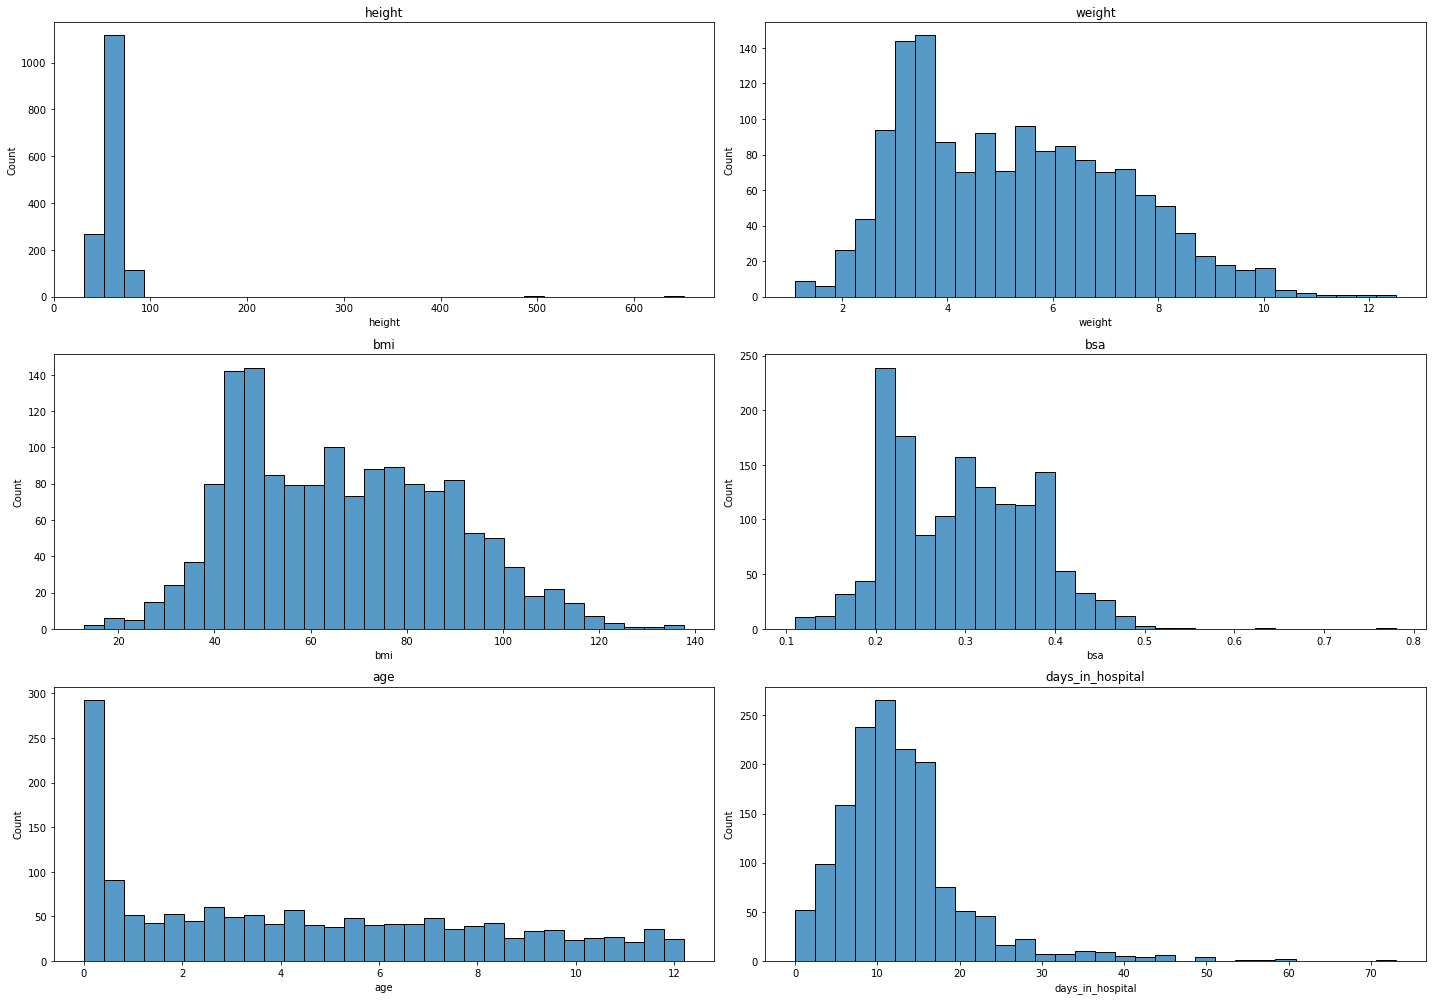

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(20,14))
axs = axs.ravel()
vals = ['height', 'weight', 'bmi', 'bsa', 'age', 'days_in_hospital']

for i in range(len(vals)):
    ax = axs[i]
    sns.histplot(ax=ax, data=df, x=df[vals[i]], bins=30)
    ax.set_title(vals[i])
    
fig.tight_layout()

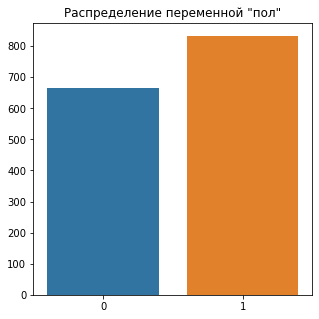

In [18]:
plt.figure(figsize=(5, 5))
sns.barplot(data=df, x=df['sex'].unique(), y=df['sex'].value_counts().values)
plt.title('Распределение переменной "пол"')
plt.show()

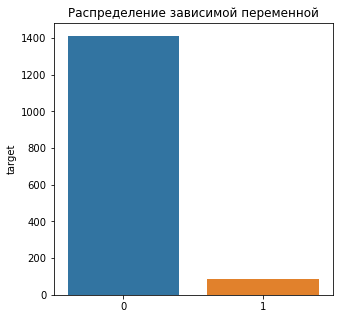

In [19]:
plt.figure(figsize=(5, 5))
sns.barplot(x=df['target'].value_counts().index,
            y=df['target'].value_counts())
plt.title('Распределение зависимой переменной')
plt.show()

In [20]:
df.isna().sum()

admittion               0
discharge               0
sex                     0
height                  2
weight                  2
bmi                     9
bsa                     9
birth                   0
total_operations        0
before_operations       0
diagnosis               0
mkb                     1
accomp_ill              0
medication_main       283
medications_taken     558
eho                    54
ekg                   210
akg                  1250
kt                   1281
first_operation         0
operation_date          0
target                  0
id                      0
age                     0
days_in_hospital        0
dtype: int64

Удалим наблюдения с пропусками в переменных `bsa` и `bmi`, т.к. для этих наблюдений отсуствует как значение `bsa`, так и значение `bmi`.

In [21]:
df.dropna(subset=['bsa', 'bmi', 'height', 'weight', 'mkb'], inplace=True)

Обработаем текстовые переменные. Почистим текст, удалив всё кроме букв и цифр с помощью регулярных выражений.

In [23]:
text_cols = df.select_dtypes('object').columns.values
df[text_cols] = df[text_cols].values.astype('U')

## ЭХОКГ

In [25]:
eho = df[['id', 'eho']].copy()

In [26]:
eho['eho'] = eho['eho'].str.lower().replace(r'[^а-яё0-9.]', ' ', regex=True)

In [27]:
# Работаю с информацией до "заключения" врача
eho['eho'] = eho['eho'].str.extract(r'(.+?)заключение').fillna('').astype('str')

In [28]:
eho['eho'][0]

'эхокг впс  02.12.2016 14 37 22    г.  лж  лп  не увеличены  кдр 2 1 см. фв 70 .  мк  не изменен  фк   14 4 мм ак  отходит от пж  створки тонкие. раскрытие полное  фк   17 мм ао  б о кла  атрезирован ла  диам. ствола   8 мм  ветвей   8 мм тк  не изменен  фк   18 мм дмжп перимембранозный 11 мм  рестриктивный. умеренно коммитирован к ао.  ооо   4 мм  перекрестный сброс функционирующий анастомоз справа  приток пж   приток лж '

In [29]:
# Фракцией выброса (ФВ) именуется процент от объема крови
eho['fv'] = eho['eho'].str.extract(r'фв *(\d*)').fillna('-1').astype('str')
eho.loc[eho['fv']=='', 'fv'] = -1
eho['fv'] = eho['fv'].astype('int')

In [30]:
# Опечатка
eho.loc[eho['fv'] == 790, 'fv'] = 79

In [31]:
# Конечный диастолический размер (КДР) левого желудочка
res = eho['eho'].str.extract(r'((лж|левый желудочек).+?кдр *\d(.| )\d)').fillna('-1').astype('str')
res2 = eho['eho'].str.extract(r'(кдр лж *\d(.| )\d)').fillna('-1').astype('str')[0]
res[1] = res2
res = res[0] + res[1]

In [32]:
eho['lg_kdr_size'] = (res.str.extract(r'((кдр |кдр лж) *(\d( |.)\d))')[2]
                      .str.replace(' ', '.', regex=True)
                      .fillna('-1').astype('float'))

In [33]:
# Гипоплазия левого желудочка
res = eho['eho'].str.extract('((лж|левый желудочек|левые отделы сердца) .+ гипоплазирован(|ы))')[0].fillna('').astype('str')
eho['lg_hipoplaz'] = res.map(lambda x: 1 if 'гипоплаз' in x else 0)

In [34]:
# Конечный диастолический размер (КДР) правого желудочка
res = eho['eho'].str.extract(r'((пж|правые отделы сердца|правый желудочек).+?увел)').fillna('-1').astype('str')
eho['pg_big'] = res[0].map(lambda x: -1 if x == '-1' else 0 if 'не увел' in x else 1)

In [35]:
# Гипертрофия правого желудочка
res = eho['eho'].str.extract(r'((пж|правые отделы сердца|правый желудочек).+?гипертр)').fillna('-1').astype('str')
eho['pg_hypertrop'] = res[0].map(lambda x: 1 if 'гиперт' in x else 0)

In [36]:
eho['pg_hypertrop'].value_counts()

0    1291
1     199
Name: pg_hypertrop, dtype: int64

In [37]:
# Дефект межжелудочковой перегородки (ДМЖП)
res = eho['eho'].str.extract(r'(дмжп.+? \d+ мм)').fillna('').astype('str')
eho['dmgp'] = res[0].str.extract(r'[а-я. ]*(\d*)').replace('', 0, regex=True).astype('int')

In [94]:
# Конечный диастолический объем (КДО)
# res = eho['eho'].str.extract(r'(кдо.+?(\d*) мл)').fillna('-1').astype('str')[1]
# eho['kdo'] = res.astype('int')

In [38]:
# Описание створок клапана
eho['flap'] = eho['eho'].str.extract(r'(створки.+?)фк').fillna('').astype('str')

In [39]:
eho = eho.fillna(0).drop('eho', axis=1)

In [40]:
eho

,id,fv,lg_kdr_size,lg_hipoplaz,pg_big,pg_hypertrop,dmgp,flap
0,0,70,2.1,0,-1,0,11,створки тонкие. раскрытие полное
1,1,68,2.0,0,1,0,11,створки тонкие
2,2,70,2.6,0,1,0,12,створки незначительно уплотнены раскрытие пол...
3,3,68,1.1,1,1,0,6,створки подвижные. кровоток ограничен.
4,4,70,2.5,0,0,1,0,створки утолщены удлинены диаметр отверстия ...
...,...,...,...,...,...,...,...,...
1495,1495,65,2.5,0,0,0,0,створки тонкие.
1496,1496,-1,-1.0,0,-1,0,0,
1497,1497,67,1.6,0,1,0,0,створки тонкие 1 группа папиллярных мышц рас...
1498,1498,-1,-1.0,0,-1,0,0,


## ЭКГ

Из тетрадки Татьяны.

In [41]:
ekg = df[['id', 'ekg']].copy()

In [42]:
ekg['ekg'] = ekg['ekg'].str.lower()

In [43]:
ekg['ekg_date'] = ekg['ekg'].str.extract(r'(\d+\.\d+\.\d{2,4})')

In [44]:
ekg['ekg_sinus'] = ekg['ekg'].str.extract(r'( синус)').notna().astype('int')

In [45]:
list_of_ss = '|'.join(['чсс', 'сердцебиений в минуту', 'сердечных сокращений'])
res = ekg['ekg'].str.extract(f'({list_of_ss}) ?=?-? ?(\d+)')[1]

In [46]:
eos_dict = {'прав': 1,
            'лев': 2,
            'норм':3, 
            'гориз':4, 
            'верт':5}

def ekg_replace(data):
    res = [eos_dict.get(x) for x in eos_dict.keys() if x in data]
    if res:
        return res[0]
    return 0

In [47]:
list_of_eos = '|'.join(['эос', 'электрической оси сердца:', 'ось сердца', 'ось'])
res = ekg['ekg'].str.extract(f'(({list_of_eos}) (отклонена)? ?(\w+))|((\w+) (положение э))')
res[3] = res[3].fillna(res[5])
ekg['ekg_eos'] = res[3]
ekg['ekg_eos'] = ekg['ekg_eos'].fillna(' ')
ekg['ekg_eos'] = ekg['ekg_eos'].map(ekg_replace)

In [48]:
ekg['ekg_qrs'] = ekg['ekg'].str.extract('(qrs) ?=?(\d(,|\.)\d+)')[1].str.replace(',','.', regex=True).astype('float')
ekg['ekg_qrst'] = ekg['ekg'].str.extract('(qrst) ?=? ?(\d(,|\.)\d+)')[1].str.replace(',','.', regex=True).astype('float')
ekg['ekg_pq'] = ekg['ekg'].str.extract('(pq) ?=? ?(\d(,|\.)\d+)')[1].str.replace(',','.', regex=True).astype('float')

In [49]:
ekg = ekg.fillna(0).drop('ekg', axis=1)

In [50]:
ekg.head()

,id,ekg_date,ekg_sinus,ekg_eos,ekg_qrs,ekg_qrst,ekg_pq
0,0,02.12.2016,1,1,0.07,0.26,0.12
1,1,13.01.2017,1,3,0.06,0.00,0.12
2,2,17.01.2017,1,1,0.00,0.00,0.00
3,3,0,1,2,0.00,0.00,0.00
4,4,14.02.17,1,1,0.00,0.00,0.00


## Количество исследований

In [51]:
analysis_count = df[['id', 'eho', 'ekg', 'akg', 'kt']].copy()

In [52]:
analysis_count['eho_count'] = (analysis_count['eho']
                               .map(lambda x: 0 if x == 'nan' else 1))

analysis_count['ekg_count'] = (analysis_count['ekg']
                               .map(lambda x: 0 if x == 'nan' else 1))

analysis_count['akg_count'] = (analysis_count['akg']
                               .map(lambda x: 0 if x == 'nan' else 1))

analysis_count['kt_count'] = (analysis_count['kt']
                              .map(lambda x: 0 if x == 'nan' else 1))

In [53]:
analysis_count['total'] = sum([analysis_count['kt_count'], analysis_count['akg_count'], 
                               analysis_count['ekg_count'], analysis_count['eho_count']]) 

In [54]:
analysis_count['total'].value_counts()

2    904
3    385
1    127
0     50
4     24
Name: total, dtype: int64

## Медикаменты, диагноз, мкб

In [55]:
df['medication_main'] = df['medication_main'].str.lower().replace(r'[^а-яА-Я0-9 ]', ' ', regex=True)
df['medications_taken'] = df['medications_taken'].str.lower().replace(r'[^а-яА-Я0-9 ]', ' ', regex=True)
df['diagnosis'] = df['diagnosis'].str.lower().replace(r'[^а-яА-Я0-9 ]', ' ', regex=True)
df['mkb'] = df['mkb'].str.lower().replace(r'[^а-яА-Яa-zA-ZёЁ0-9. ]', ' ', regex=True)

Лемматизируем токены в диагнозе.

In [58]:
%%time
df['diagnosis'] = df['diagnosis'].apply(lambda series: ''.join(Mystem().lemmatize(series)))

CPU times: user 1.55 s, sys: 20.5 s, total: 22.1 s
Wall time: 27min 12s


Оставим в выборке только 12 признаков. В будущем необходимо выбрать способ кодирования текстовых признаков. Можно попробовать найти дообученный на мед. текстах BERT.

### BERT

Не дообученный берт не помог улучшить качество.

In [61]:
# import torch
# import transformers 
# from tqdm import notebook
# import numpy as np
# 
# df.reset_index(inplace=True, drop=True)
# 
# tokenizer = transformers.BertTokenizer(vocab_file='/Users/anshilina/practicum/rubert/vocab.txt')
# 
# tokenized = []
# for i in notebook.tqdm(range(df['diagnosis'].shape[0])):
#     tokenized.append(tokenizer.encode(df['diagnosis'][i], max_length=512, truncation=True, add_special_tokens=True))
# 
# max_vector = max(len(token) for token in tokenized)
# padded = np.array([i + [0]*(max_vector - len(i)) for i in tokenized])
# attention_mask = np.where(padded != 0, 1, 0)
# 
# config = transformers.BertConfig.from_json_file('/Users/anshilina/practicum/rubert/config.json')
# model = transformers.BertModel.from_pretrained('/Users/anshilina/practicum/rubert/pytorch_model.bin', config=config) 
# 
# batch_size = 149
# embeddings = []
# 
# for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
#   
#     batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
#     attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]) 
#   
#     with torch.no_grad():
#         batch_embeddings = model(batch, attention_mask=attention_mask_batch)
#     embeddings.append(batch_embeddings[0][:,0,:].numpy()) 
#   
#   
# diagnosis = pd.DataFrame(np.concatenate(embeddings))
# diagnosis.columns = [str(i) + 'emb' for i in diagnosis.columns]
# df = df.join(diagnosis)

In [62]:
# df.drop(['diagnosis'], axis=1, inplace=True)

В будущем необходимо предобработать и добавить `akg` и `kt` в модель.

In [63]:
df = df[['id', 'sex', 'height', 'weight', 'bmi', 'bsa', 
         'age', 'diagnosis', 'mkb', 'medication_main', 
         'medications_taken',  'days_in_hospital', 'target']].copy()

In [64]:
median_fv = eho.loc[eho['fv'] != -1, 'fv'].describe()[5]
eho['fv'] = eho['fv'].map(lambda x: median_fv if x == -1 else x)

In [65]:
median_lg_kdr = eho.loc[eho['lg_kdr_size'] != -1, 'lg_kdr_size'].describe()[5]
eho['fv'] = eho['fv'].map(lambda x: median_lg_kdr if x == -1 else x)

In [66]:
eho = eho[['id', 'fv', 'lg_kdr_size', 'lg_hipoplaz', 
           'pg_big', 'pg_hypertrop', 'dmgp']].copy()

In [67]:
ekg = ekg[['id', 'ekg_sinus', 'ekg_eos', 'ekg_qrs', 'ekg_qrst', 'ekg_pq']].copy()

In [68]:
analysis_count = analysis_count[['id', 'total']].copy()

In [69]:
df = df.merge(eho, on='id', how='left')
df = df.merge(ekg, on='id', how='left')
df = df.merge(analysis_count, on='id', how='left')

In [71]:
df.drop('id', axis=1, inplace=True)

In [73]:
df.to_csv('new_df3.csv', index=False)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1490 entries, 0 to 1489
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                1490 non-null   int64  
 1   height             1490 non-null   float64
 2   weight             1490 non-null   float64
 3   bmi                1490 non-null   float64
 4   bsa                1490 non-null   float64
 5   age                1490 non-null   float64
 6   diagnosis          1490 non-null   object 
 7   mkb                1490 non-null   object 
 8   medication_main    1490 non-null   object 
 9   medications_taken  1490 non-null   object 
 10  days_in_hospital   1490 non-null   int64  
 11  target             1490 non-null   int64  
 12  fv                 1490 non-null   float64
 13  lg_kdr_size        1490 non-null   float64
 14  lg_hipoplaz        1490 non-null   int64  
 15  pg_big             1490 non-null   int64  
 16  pg_hypertrop       1490 

## Обучение моделей

In [4]:
# df = pd.read_csv('test.csv') не прогонять эту строку, если не загружаешь датасет
df.drop(['mkb'], axis=1, inplace=True)

In [6]:
features, target = df.drop('target', axis=1), df['target']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, stratify=target, test_size=0.25, random_state=42)

Создадим пайплайны для предобаботки текстовых и числовых переменных. Для лиейных моделей будем скалировать числовые переменные, для деревянных – нет.

In [7]:
numerical = ['height', 'weight', 'bmi', 'bsa', 'age', 
             'days_in_hospital', 'fv', 'lg_kdr_size', 
             'dmgp', 'ekg_qrs', 'ekg_qrst', 'ekg_pq', 'total']
num_pipe = Pipeline([('scaler', StandardScaler())])

categorical = ['pg_big', 'ekg_eos'] # 'mkb'
cat_pipe = Pipeline([('ohe', OneHotEncoder())])

stop_words = list(stopwords.words('russian')) 
text = ['diagnosis', 'medication_main', 'medications_taken']


linear_preprocessor = ColumnTransformer(
    transformers = [(x, TfidfVectorizer(stop_words=stop_words), x) for x in text] + \
                   [('num', num_pipe, numerical), ('cat', cat_pipe, categorical)], 
    remainder='passthrough')


tree_preprocessor = ColumnTransformer(
    transformers = [(x, TfidfVectorizer(stop_words=stop_words), x) for x in text] + \
                   [('cat', cat_pipe, categorical)],
    remainder='passthrough')

Выборку разделим в соотношении 75:25. Используем стратификацию при разбиении. Также будем использовать `StratifiedKFold` при разбиении выборки на фолды на кросс-валидации.

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Логистическая регрессия

In [9]:
model_lin = Pipeline([('preprocessor', linear_preprocessor),
                      ('model', LogisticRegression(random_state=42, 
                                                   penalty='l2',
                                                   solver='liblinear', 
                                                   max_iter=400,
                                                   class_weight='balanced'))])

In [10]:
cross_val_score(model_lin, features_train, target_train, 
                cv=skf.split(features_train, target_train), 
                scoring='precision')

array([0.66666667, 0.44444444, 0.75      , 0.61538462, 0.52941176])

### Catboost

In [11]:
cat_clf = Pipeline([('preprocessor', tree_preprocessor),
                    ('model', CatBoostClassifier(class_weights=dict(zip(np.unique(target_train), 
                                                                        compute_class_weight(class_weight='balanced', 
                                                                                             classes=np.unique(target_train), 
                                                                                             y=target_train))), silent=True, random_seed=42))])

In [12]:
cross_val_score(cat_clf, features_train, target_train, cv=skf.split(features_train, target_train))

array([0.98214286, 0.98660714, 0.98654709, 0.98206278, 0.98206278])

Используем встроенные механихмы предобработки.

In [13]:
train_pool = Pool(features_train, 
                  target_train,
                  cat_features=categorical,
                  text_features=text)

valid_pool = Pool(features_test, 
                  target_test,
                  cat_features=categorical,
                  text_features=text)

model = CatBoostClassifier(random_seed=42, verbose=250, eta=0.5, iterations=500,
                           auto_class_weights='Balanced')

model.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3241929	test: 0.3304375	best: 0.3304375 (0)	total: 73.9ms	remaining: 36.9s
250:	learn: 0.0022305	test: 0.4093579	best: 0.2326073 (13)	total: 18.7s	remaining: 18.6s
499:	learn: 0.0022193	test: 0.4054478	best: 0.2326073 (13)	total: 38s	remaining: 0us

bestTest = 0.2326073301
bestIteration = 13

Shrink model to first 14 iterations.


#### Tree-based (or Gini) importance

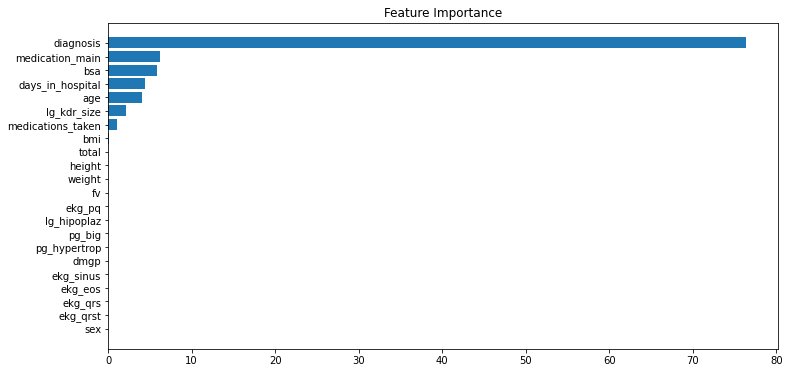

In [14]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Feature Importance');

#### Permutation importance

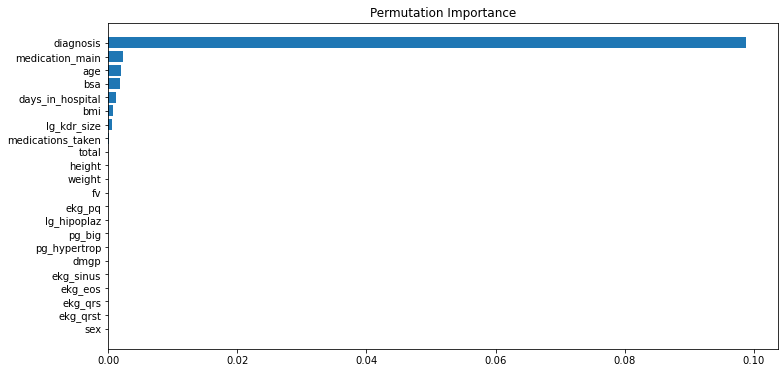

In [15]:
perm_importance = permutation_importance(model, features_train, target_train, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Permutation Importance');

### Decision tree

In [49]:
baseline_clf = Pipeline([('preprocessor', tree_preprocessor),
                         # ('smote', SMOTE(random_state=42)),
                         # ('border_smote', BorderlineSMOTE(random_state=42, n_jobs=-1)),
                         # ('smote', SMOTEENN(smote=SMOTE(random_state=42, k_neighbors=3), random_state=42)),
                         # ('adasyn', ADASYN(random_state=42, n_neighbors=3)),
                         ('svm', SVMSMOTE(random_state=42)),
                         ('model', DecisionTreeClassifier(class_weight='balanced',
                                                          random_state=42))])

baseline_grid = {'model__max_depth':[5,8,11]}

baseline_gs = GridSearchCV(baseline_clf, baseline_grid, 
                           scoring='f1', n_jobs=-1, 
                           cv=skf.split(features_train, target_train))

In [50]:
start = time.time()
baseline_gs.fit(features_train, target_train)
baseline_gs_time = time.time() - start

In [51]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(baseline_gs_time, 2)} сек')
print(f'Время обучения модели: {round(baseline_gs.cv_results_["mean_fit_time"][baseline_gs.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(baseline_gs.cv_results_["mean_score_time"][baseline_gs.best_index_], 5)} сек')
print(f'Качество модели по кросс-валидации: {baseline_gs.best_score_}')
print(f'Лучшие значения параметров: {baseline_gs.best_params_}')

Результаты подбора параметров.

Время подбора параметров: 4.66 сек
Время обучения модели: 0.21009 сек
Время предсказания модели: 0.02352 сек
Качество модели по кросс-валидации: 0.27142857142857146
Лучшие значения параметров: {'model__max_depth': 8}


### Logistic regression

In [52]:
lin_clf = Pipeline([('preprocessor', linear_preprocessor),
                    # ('smote', SMOTE(random_state=42)),
                    # ('border_smote', BorderlineSMOTE(random_state=42, n_jobs=-1)),
                    # ('smoteen', SMOTEENN(smote=SMOTE(random_state=42, k_neighbors=3), random_state=42)),
                    # ('adasyn', ADASYN(random_state=42, n_neighbors=3)),
                    ('svm', SVMSMOTE(random_state=42)),
                    ('model', LogisticRegression(class_weight='balanced',
                                                 solver='liblinear'))])

In [53]:
lin_grid = {'model__penalty': ['l1', 'l2'],
            'model__C' : range(1, 8)}

lin_gs = GridSearchCV(lin_clf, lin_grid, 
                      scoring='f1', n_jobs=-1, 
                      cv=skf.split(features_train, target_train))

In [54]:
start = time.time()
lin_gs.fit(features_train, target_train)
lin_gs_time = time.time() - start

In [55]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(lin_gs_time, 2)} сек')
print(f'Время обучения модели: {round(lin_gs.cv_results_["mean_fit_time"][lin_gs.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(lin_gs.cv_results_["mean_score_time"][lin_gs.best_index_], 5)} сек')
print(f'Качество модели по кросс-валидации: {lin_gs.best_score_}')
print(f'Лучшие значения параметров: {lin_gs.best_params_}')

Результаты подбора параметров.

Время подбора параметров: 2.03 сек
Время обучения модели: 0.18239 сек
Время предсказания модели: 0.02708 сек
Качество модели по кросс-валидации: 0.45999999999999996
Лучшие значения параметров: {'model__C': 5, 'model__penalty': 'l2'}


### Random forest

In [56]:
forest_clf = Pipeline([('preprocessor', tree_preprocessor),
                       # ('smote', SMOTE(random_state=42)),
                       # ('border_smote', BorderlineSMOTE(random_state=42, n_jobs=-1)),
                       # ('smote', SMOTEENN(smote=SMOTE(random_state=42, k_neighbors=3), random_state=42)),
                       # ('adasyn', ADASYN(random_state=42, n_neighbors=3)),
                       ('svm', SVMSMOTE(random_state=42)),
                       ('model', RandomForestClassifier(class_weight='balanced',
                                                        random_state=42))])

In [57]:
forest_grid = {'model__max_depth':[4,5,8,10],
               'model__n_estimators': range(10, 50, 5)}

forest_gs = GridSearchCV(forest_clf, forest_grid, 
                         scoring='f1', n_jobs=-1, 
                         cv=skf.split(features_train, target_train))

In [58]:
start = time.time()
forest_gs.fit(features_train, target_train)
forest_gs_time = time.time() - start

In [59]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(forest_gs_time, 2)} сек')
print(f'Время обучения модели: {round(forest_gs.cv_results_["mean_fit_time"][forest_gs.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(forest_gs.cv_results_["mean_score_time"][forest_gs.best_index_], 5)} сек')
print(f'Качество модели по кросс-валидации: {forest_gs.best_score_}')
print(f'Лучшие значения параметров: {forest_gs.best_params_}')

Результаты подбора параметров.

Время подбора параметров: 5.94 сек
Время обучения модели: 0.24985 сек
Время предсказания модели: 0.03006 сек
Качество модели по кросс-валидации: 0.3333333333333333
Лучшие значения параметров: {'model__max_depth': 4, 'model__n_estimators': 35}


### Balanced forest

In [60]:
balanced_forest_clf = Pipeline([('preprocessor', tree_preprocessor),
                                # ('smote', SMOTE(random_state=42)),
                                # ('border_smote', BorderlineSMOTE(random_state=42, n_jobs=-1)),
                                # ('smote', SMOTEENN(smote=SMOTE(random_state=42, k_neighbors=3), random_state=42)),
                                # ('adasyn', ADASYN(random_state=42, n_neighbors=3)),
                                ('svm', SVMSMOTE(random_state=42)),
                                ('model', BalancedRandomForestClassifier(random_state=42, 
                                                                         class_weight='balanced',
                                                                         n_jobs=-1))])

In [61]:
# balanced_forest_grid = {'model__max_depth':[4,5,8,10],
#                         'model__n_estimators': range(10, 50, 5)}

# balanced_forest_grid = GridSearchCV(balanced_forest_clf, balanced_forest_grid, 
#                                     scoring='f1', n_jobs=-1, 
#                                     cv=skf.split(features_train, target_train))

In [63]:
# start = time.time()
# balanced_forest_grid.fit(features_train, target_train)
# balanced_forest_time = time.time() - start

In [64]:
# print('Результаты подбора параметров.\n')
# print(f'Время подбора параметров: {round(balanced_forest_time, 2)} сек')
# print(f'Время обучения модели: {round(balanced_forest_grid.cv_results_["mean_fit_time"][balanced_forest_grid.best_index_], 5)} сек')
# print(f'Время предсказания модели: {round(balanced_forest_grid.cv_results_["mean_score_time"][balanced_forest_grid.best_index_], 5)} сек')
# print(f'Качество модели по кросс-валидации: {balanced_forest_grid.best_score_}')
# print(f'Лучшие значения параметров: {balanced_forest_grid.best_params_}')

### Catboost

In [16]:
cat_clf = Pipeline([('preprocessor', tree_preprocessor),
                    # ('smote', SMOTE(random_state=42)),
                    # ('border_smote', BorderlineSMOTE(random_state=42, n_jobs=-1)),
                    # ('smote', SMOTEENN(smote=SMOTE(random_state=42, k_neighbors=3), random_state=42)),   
                    # ('adasyn', ADASYN(random_state=42, n_neighbors=3)),
                    ('svm', SVMSMOTE(random_state=42)),
                    ('model', CatBoostClassifier(class_weights=dict(zip(np.unique(target_train), 
                                                                        compute_class_weight(class_weight='balanced', 
                                                                                             classes=np.unique(target_train), 
                                                                                             y=target_train))), 
                                                 silent=True, random_seed=42))])

In [17]:
cat_grid = {'model__depth':[5,8,10],
            'model__iterations': [100, 150, 200]} 

cat_gs = GridSearchCV(cat_clf, cat_grid, 
                      scoring='f1', n_jobs=-1, 
                      cv=skf.split(features_train, target_train))

In [18]:
start = time.time()
cat_gs.fit(features_train, target_train)
cat_gs_time = time.time() - start

In [68]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(cat_gs_time // 60, 2)} мин')
print(f'Время обучения модели: {round(cat_gs.cv_results_["mean_fit_time"][cat_gs.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(cat_gs.cv_results_["mean_score_time"][cat_gs.best_index_], 5)} сек')
print(f'Качество модели по кросс-валидации: {cat_gs.best_score_}')
print(f'Лучшие значения параметров: {cat_gs.best_params_}')

Результаты подбора параметров.

Время подбора параметров: 4.0 мин
Время обучения модели: 89.99023 сек
Время предсказания модели: 0.06881 сек
Качество модели по кросс-валидации: 0.38
Лучшие значения параметров: {'model__depth': 10, 'model__iterations': 200}


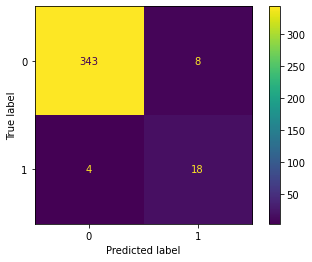

In [19]:
ConfusionMatrixDisplay(confusion_matrix(target_test,  cat_gs.best_estimator_.predict(features_test))).plot();

In [23]:
print(classification_report(target_test, cat_gs.best_estimator_.predict(features_test)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       351
           1       0.69      0.82      0.75        22

    accuracy                           0.97       373
   macro avg       0.84      0.90      0.87       373
weighted avg       0.97      0.97      0.97       373

